### Installation

`conda install r-essentials r-devtools bioconductor-gviz bioconductor-genomicranges bioconductor-rtracklayer -y bioconductor-biocgenerics bioconductor-delayedarray bioconductor-delayedmatrixstats bioconductor-limma bioconductor-s4vectors bioconductor-singlecellexperiment bioconductor-summarizedexperiment r-units r-sf `

`devtools::install_github('cole-trapnell-lab/monocle3')`  
`devtools::install_github('cole-trapnell-lab/cicero-release', ref = "monocle3")`

Vignette: https://cole-trapnell-lab.github.io/cicero-release/docs_m3/

### Import packages

In [1]:
library(cicero)
library(data.table)
library(Matrix)
library(proxy)
library(reshape2)
library(BuenColors)
library(umap)

Loading required package: monocle3
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

### Preprocess

`bsub < count_reads_peaks.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 12178

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 385237  12178

In [5]:
df_regions = read.csv("../../input/combined.sorted.merged.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 385237      3

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(peaknames)

[1] "chr1_3002715_3002962" "chr1_3037090_3037634" "chr1_3084622_3085850"
[4] "chr1_3103610_3104006" "chr1_3106869_3107182" "chr1_3109389_3111052"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 2))

[1] "AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT"
[2] "AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC"
[3] "AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC"
[4] "AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC"
[5] "AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC"
[6] "AGCGATAGAGTTGAATCAAAGCTAGGTTCCTATCCT"

In [10]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 2)
rownames(datafr) = peaknames

In [11]:
datafr[1:5,1:5]

,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,AGCGATAGAATATTACTTTCCGCGGACTGTACTGAC,AGCGATAGACCAGGCGCATGGCAGCTCGATAGAGGC,AGCGATAGAGATTACGTTGCGCAATGACGTACTGAC,AGCGATAGAGGTCAGCTTGGAGTTGCGTGTACTGAC
chr1_3002715_3002962,0,0,0,0,0
chr1_3037090_3037634,0,0,0,0,0
chr1_3084622_3085850,0,0,0,0,0
chr1_3103610_3104006,0,0,0,0,0
chr1_3106869_3107182,0,0,0,0,0


In [12]:
dim(datafr)

[1] 385237  12178

In [13]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [14]:
mat_sparse = as(datafr, "dgTMatrix")
cicero_data = data.frame(cbind(Peak=rownames(datafr)[mat_sparse@i+1],
                               Cell=colnames(datafr)[mat_sparse@j+1],
                               Count=mat_sparse@x),stringsAsFactors = FALSE)
cicero_data$Count = as.numeric(cicero_data$Count)

In [15]:
head(cicero_data)

Peak,Cell,Count
<chr>,<chr>,<dbl>
chr1_3254750_3255907,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,2
chr1_3378202_3378888,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,2
chr1_6443336_6444923,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,2
chr1_6584548_6585071,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,1
chr1_7127882_7129914,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,2
chr1_7136712_7137602,AGCGATAGAATACGATAATGGCAGCTCGCAGGACGT,1


### Obtain Feature Matrix

In [16]:
start_time <- Sys.time()

In [17]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [18]:
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)

In [19]:
pData(input_cds)$label = metadata[rownames(pData(input_cds)),'label']

In [20]:
dim(input_cds)

[1] 385237  12178

In [21]:
#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

In [22]:
dim(input_cds)

[1] 385237  12178

In [23]:
input_cds

class: cell_data_set 
dim: 385237 12178 
metadata(1): cds_version
assays(1): counts
rownames(385237): chr1_3002715_3002962 chr1_3037090_3037634 ...
  chrY_629891_631022 chrY_631121_631487
rowData names(5): site_name chr bp1 bp2 num_cells_expressed
colnames(12178): AGCGATAGAACGAATTCGAAGCCTACGACCTATCCT
  AGCGATAGAACGAATTCGAAGCCTACGATATAGCCT ...
  TCTCGCGCTTGGTAAGGATCAATATCGAGGCTCTGA
  TCTCGCGCTTGGTAAGGATTGGTAGTCGTATAGCCT
colData names(4): cells Size_Factor num_genes_expressed label
reducedDimNames(0):
spikeNames(0):

In [24]:
set.seed(2019)
input_cds <- monocle3::detect_genes(input_cds)

In [25]:
input_cds <- monocle3::estimate_size_factors(input_cds)

In [26]:
input_cds <- monocle3::preprocess_cds(input_cds, method = "PCA")

In [27]:
input_cds <- monocle3::reduce_dimension(input_cds, max_components = 2,
                        reduction_method = 'tSNE', norm_method = "PCA")

In [28]:
tsne_coords <- reducedDims(input_cds)$tSNE

In [29]:
head(tsne_coords)

AGCGATAGAACGAATTCGAAGCCTACGACCTATCCT,5.753484,7.379997
AGCGATAGAACGAATTCGAAGCCTACGATATAGCCT,20.106651,4.298927
AGCGATAGAACGAATTCGACTGAGCGACTATAGCCT,-34.422202,22.735345
AGCGATAGAACGAATTCGCAATGAGTCCCAGGACGT,40.481276,-8.924276
AGCGATAGAACGAATTCGCCTCCGACGGGTACTGAC,22.238024,5.116645
AGCGATAGAACGAATTCGGCGATTGCAGCCTATCCT,17.932063,-20.208207


In [30]:
df_tsne_coords = data.frame(cbind(tsne_coords,as.character(pData(input_cds)$label)),stringsAsFactors = FALSE)
colnames(df_tsne_coords) = c('tsne_1','tsne_2','label')
df_tsne_coords$tsne_1 = as.numeric(df_tsne_coords$tsne_1)
df_tsne_coords$tsne_2 = as.numeric(df_tsne_coords$tsne_2)

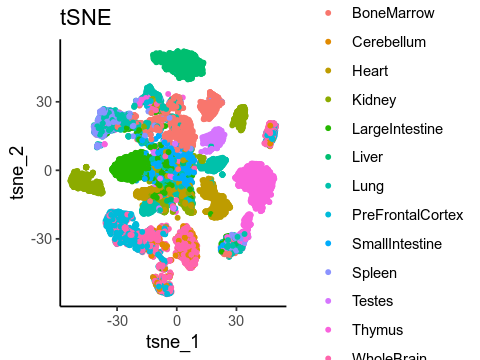

In [31]:
options(repr.plot.width=4, repr.plot.height=3)
p <- ggplot(shuf(df_tsne_coords), aes(x = tsne_1, y = tsne_2, color = label)) +
  geom_point(size = 1)+
  ggtitle('tSNE') + theme_classic()
p

In [32]:
mouse.mm9.genome = read.table('../../input/mm9/mm9.chrom.sizes')
genome_ref = mouse.mm9.genome
file_tss='../../input/mm9/mm9-tss.bed'

In [33]:
head(genome_ref)

V1,V2
<fct>,<int>
chr1,197195432
chr2,181748087
chr3,159599783
chr4,155630120
chr5,152537259
chr6,149517037


In [ ]:
row.names(tsne_coords) <- row.names(pData(input_cds))
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords)
conns <- run_cicero(cicero_cds, genome_ref) # Takes a few minutes to run

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.217377279116039
Median shared cells bin-bin: 0


In [ ]:
gene_annotation <- read.table(file_tss,sep='\t')
names(gene_annotation)[4] <- "gene"    
gene_annotation_pos <- subset(gene_annotation, V5 == "+")
gene_annotation_pos$V3 <- gene_annotation_pos$V2 + 1
gene_annotation_neg <- subset(gene_annotation, V5 == "-")
gene_annotation_neg$V2 <- gene_annotation_neg$V3 - 1
tss <- rbind(gene_annotation_pos, gene_annotation_neg)    

In [ ]:
input_cds <- annotate_cds_by_site(input_cds, tss)
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, conns)
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0,]

# make a list of num_genes_expressed
num_genes <- pData(input_cds)$num_genes_expressed
names(num_genes) <- row.names(pData(input_cds))

# normalize
cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)    
fm_Cicero = as.matrix(cicero_gene_activities)

In [ ]:
end_time <- Sys.time()

In [ ]:
end_time - start_time

In [ ]:
all(colnames(fm_Cicero) == rownames(metadata))

In [ ]:
saveRDS(fm_Cicero, file = '../../output/feature_matrices/FM_Cicero_cusanovich2018subset.rds')

### Downstream Analysis

In [ ]:
df_umap_Cicero <- umap(t(fm_Cicero))$layout

In [ ]:
df_umap = data.frame(cbind(df_umap_Cicero,metadata[rownames(pData(input_cds)),'label']),stringsAsFactors = FALSE)
colnames(df_umap) = c('umap_1','umap_2','label')
df_umap$umap_1 = as.numeric(df_umap$umap_1)
df_umap$umap_2 = as.numeric(df_umap$umap_2)
options(repr.plot.width=5, repr.plot.height=4)
p <- ggplot(df_umap, aes(x = umap_1, y = umap_2, color = label)) +
  geom_point(size = 1) + 
  ggtitle('Cicero') + theme_classic()
p

In [ ]:
sessionInfo()

In [ ]:
save.image(file = 'Cicero_cusanovich2018subset.RData')